### import

In [74]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor, plot_tree
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# = = = = = =
# own stuff

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today

In [3]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


### Dummy Creation / Feature Engineering

#### holidays

In [6]:
# get all years in dataframe
uniq_yrs = [2016]

# get holidays for germany for all states and combine them into one single dict
states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
            'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']

holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
for state in states:
    holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

# sort holidays
holidays_de = dict(sorted(holidays_de.items()))
print(holidays_de)

{datetime.date(2016, 1, 1): 'Neujahr', datetime.date(2016, 1, 6): 'Heilige Drei Könige', datetime.date(2016, 3, 25): 'Karfreitag', datetime.date(2016, 3, 27): 'Ostersonntag', datetime.date(2016, 3, 28): 'Ostermontag', datetime.date(2016, 5, 1): 'Erster Mai', datetime.date(2016, 5, 5): 'Christi Himmelfahrt', datetime.date(2016, 5, 15): 'Pfingstsonntag', datetime.date(2016, 5, 16): 'Pfingstmontag', datetime.date(2016, 5, 26): 'Fronleichnam', datetime.date(2016, 8, 15): 'Mariä Himmelfahrt', datetime.date(2016, 10, 3): 'Tag der Deutschen Einheit', datetime.date(2016, 10, 31): 'Reformationstag', datetime.date(2016, 11, 1): 'Allerheiligen', datetime.date(2016, 11, 16): 'Buß- und Bettag', datetime.date(2016, 12, 25): 'Erster Weihnachtstag', datetime.date(2016, 12, 26): 'Zweiter Weihnachtstag'}


#### feature engineering for trees

In [125]:
def features_for_tree(df, holiday_method='simple', lags=None):

    df_out = df.copy()

    # - - - - - - - - - - - - - - - - - - - - - -
    # basic features 
    # - - - - - - - - - - - - - - - - - - - - - -

    # add hour
    df_out["hour"] = df_out['timestamp_CET'].dt.hour
    # add weekday
    df_out["weekday"] = df_out['timestamp_CET'].dt.weekday
    # add month
    df_out["month"] = df_out['timestamp_CET'].dt.month
    # add weeknum
    # df_out["weeknum"] = df_out['timestamp_CET'].dt.isocalendar().week

    # - - - - - - - - - - - - - - - - - - - - - -
    # holidays
    # - - - - - - - - - - - - - - - - - - - - - -

    # get all years in dataframe
    uniq_yrs = df_out['timestamp_CET'].dt.year.unique()

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
              'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']
    
    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

    # sort holidays
    holidays_de = dict(sorted(holidays_de.items()))
    holidays_de_dates = list(holidays_de.keys())

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # only one holiday dummy for all holidays
    if holiday_method == 'simple':

        df_out['is_holiday'] = df_out['timestamp_CET'].dt.date.isin(holidays_de_dates).astype(int)

    # create separate dummies for each holiday ...
    if holiday_method == 'separate' :

        # newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
        # create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
        df_out['is_holiday_newyear_d31'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 31))
        df_out['is_holiday_newyear_d01'] = ((df_out['timestamp_CET'].dt.month == 1) & (df_out['timestamp_CET'].dt.day == 1))

        # Heilige Drei Könige (01.06)
        threekings_dates = [k for k, v in holidays_de.items() if v == 'Heilige Drei Könige']
        df_out['is_holiday_threekings'] = df_out['timestamp_CET'].dt.date.isin(threekings_dates)

        # Karfreitag (easter - 2d)
        karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
        df_out['is_holiday_karfreitag'] = df_out['timestamp_CET'].dt.date.isin(karfreitag_dates)

        # Eastermonday (easter + 1d)
        easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
        df_out['is_holiday_easter'] = df_out['timestamp_CET'].dt.date.isin(easter_dates)

        # Erster Mai / Tag der Arbeit (05.01)
        erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
        df_out['is_holiday_erstermai'] = df_out['timestamp_CET'].dt.date.isin(erstermai_dates)

        # Christi Himmelfahrt (easter + 39d)
        himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
        df_out['is_holiday_himmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(himmelfahrt_dates)

        # Pfingstmontag (easter + 50d)
        pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
        df_out['is_holiday_pfingstmontag'] = df_out['timestamp_CET'].dt.date.isin(pfingstmontag_dates)

        # Fronleichnam (easter + 60d)
        fronleichnam_dates = [k for k, v in holidays_de.items() if v == 'Fronleichnam']
        df_out['is_holiday_fronleichnam'] = df_out['timestamp_CET'].dt.date.isin(fronleichnam_dates)

        # Maria Himmelfahrt (08.15)
        mariahimmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Mariä Himmelfahrt']
        df_out['is_holiday_mariahimmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(mariahimmelfahrt_dates)

        # Tag der Deutschen Einheit (10.03)
        einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
        df_out['is_holiday_einheit'] = df_out['timestamp_CET'].dt.date.isin(einheit_dates)

        # Reformationstag (10.31)
        reformationstag_dates = [k for k, v in holidays_de.items() if v == 'Reformationstag']
        df_out['is_holiday_reformationstag'] = df_out['timestamp_CET'].dt.date.isin(reformationstag_dates)

        # Allerheiligen (11.01)
        allerheiligen_dates = [k for k, v in holidays_de.items() if v == 'Allerheiligen']
        df_out['is_holiday_allerheiligen'] = df_out['timestamp_CET'].dt.date.isin(allerheiligen_dates)

        # christmas = list of datetimes from 12.24 to 12.26 
        df_out['is_holiday_xmas_d23'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 23))
        df_out['is_holiday_xmas_d24'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 24))
        df_out['is_holiday_xmas_d25'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 25))
        df_out['is_holiday_xmas_d26'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 26))

        # brückentage zwischen weihnachten und neujahr
        # 12.27, 12.28, 12.29, 12.30
        df_out['is_holiday_xmas2newyear'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day.isin([27,28,29,30])))

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # reformat all columns that begin with "is_holiday" to int
        for col in df_out.columns:
            if col.startswith('is_holiday'):
                df_out[col] = df_out[col].astype(int)

    # - - - - - - - - - - - - - - - - - - - - - -
    # lags
    # - - - - - - - - - - - - - - - - - - - - - -

    # add lagged versions of column 'gesamt' based on input lags list of lagged values
    if lags is not None:
        for lag in lags:
            df_out[f"lag_{lag}"] = df_out["gesamt"].shift(lag)

        # take biggest value in lags and remove first rows in df_out to get rid of NaNs
        max_lag = max(lags)
        df_out = df_out[max_lag:]

    # - - - - - - - - - - - - - - - - - - - - - -

    df_out.drop(columns=["timestamp_CET"], inplace=True)

    return df_out

In [127]:
features_for_tree(df_energy, holiday_method='separate', lags=[24, 7*24]).loc["2016-12-25 00:00:00":"2016-12-26 23:00:00"]

,gesamt,hour,weekday,month,is_holiday_newyear_d31,is_holiday_newyear_d01,is_holiday_threekings,is_holiday_karfreitag,is_holiday_easter,is_holiday_erstermai,...,is_holiday_einheit,is_holiday_reformationstag,is_holiday_allerheiligen,is_holiday_xmas_d23,is_holiday_xmas_d24,is_holiday_xmas_d25,is_holiday_xmas_d26,is_holiday_xmas2newyear,lag_24,lag_168
timestamp_UTC,,,,,,,,,,,,,,,,,,,,,
2016-12-25 00:00:00+00:00,"40,569.75",1,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"44,726.25","46,643.25"
2016-12-25 01:00:00+00:00,"38,887.50",2,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"42,974.25","45,223.50"
2016-12-25 02:00:00+00:00,"38,438.75",3,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"42,794.75","44,862.00"
2016-12-25 03:00:00+00:00,"38,509.25",4,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"42,813.00","45,072.25"
2016-12-25 04:00:00+00:00,"38,467.75",5,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"42,454.50","44,860.00"
2016-12-25 05:00:00+00:00,"37,968.25",6,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"43,460.25","44,396.25"
2016-12-25 06:00:00+00:00,"40,463.25",7,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"46,669.75","46,195.00"
2016-12-25 07:00:00+00:00,"44,204.00",8,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"51,336.00","49,574.00"
2016-12-25 08:00:00+00:00,"48,856.25",9,6,12,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"55,082.00","52,837.25"


#### create dummies

In [21]:
def create_dummy_df(df, hour_method='simple', holiday_method='simple'):

    df_out = df.copy()

    # binary dummy var for each month
    dummy_month = pd.get_dummies(df_out['timestamp_CET'].dt.month, prefix='month').astype(int)
    # leave out first month to avoid multicollinearity
    dummy_month = dummy_month.iloc[:, 1:]

    # binary dummy var for each weekday
    dummy_weekday = pd.get_dummies(df_out['timestamp_CET'].dt.weekday, prefix='weekday').astype(int)
    # leave out first weekday to avoid multicollinearity
    dummy_weekday = dummy_weekday.iloc[:, 1:]

    # - - - - - - - - -
    # concat dummies
    df_out = pd.concat([df_out, dummy_month], axis=1)
    df_out = pd.concat([df_out, dummy_weekday], axis=1)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create hour dummies

    if hour_method == 'simple':

        # binary dummy var for each hour
        dummy_hour = pd.get_dummies(df_out['timestamp_CET'].dt.hour, prefix='hour').astype(int)
        # leave out first hour to avoid multicollinearity
        dummy_hour = dummy_hour.iloc[:, 1:]
        df_out = pd.concat([df_out, dummy_hour], axis=1)

    if hour_method == 'seasonal':

        # separate hourly dummy vars for summer and winter months
        summer_months = [4, 5, 6, 7, 8, 9]
        df_out['is_summer'] = df_out['timestamp_CET'].dt.month.isin(summer_months).astype(int)

        # create dummy variables for each hour in summer months
        for hr in range(1, 24):
            # skip hour 0 in summer to avoid multicollinearity
            df_out[f'hour_{hr}_summer'] = ((df_out['is_summer'] == 1) & (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

        for hr in range(1, 24):
            # skip hour 0 in winter to avoid multicollinearity
            df_out[f'hour_{hr}_winter'] = ((df_out['is_summer'] == 0) & (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

        # drop is_summer
        df_out.drop(columns=['is_summer'], inplace=True)

    if hour_method == 'monthly':

        # separate hourly dummy vars for EVERY month
        month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
                    6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
                    11: 'November', 12: 'December'}

        for m_idx in range(1, 13):
            
            m_name = month_dict[m_idx][:3].lower() # short version of month name

            for hr in range(1, 24):
                # skip hour 0 to avoid multicollinearity
                df_out[f'hour_{hr}_{m_name}'] = ((df_out['timestamp_CET'].dt.month == m_idx) & 
                                                 (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create holiday dummies

    # get all years in dataframe
    uniq_yrs = df_out['timestamp_CET'].dt.year.unique()

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
              'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']
    
    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

    # sort holidays
    holidays_de = dict(sorted(holidays_de.items()))
    holidays_de_dates = list(holidays_de.keys())

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # only one holiday dummy for all holidays
    if holiday_method == 'simple':

        df_out['is_holiday'] = df_out['timestamp_CET'].dt.date.isin(holidays_de_dates).astype(int)

    # create separate dummies for each holiday ...
    if holiday_method == 'separate' :

        # newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
        # create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
        df_out['is_holiday_newyear_d31'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 31))
        df_out['is_holiday_newyear_d01'] = ((df_out['timestamp_CET'].dt.month == 1) & (df_out['timestamp_CET'].dt.day == 1))

        # Heilige Drei Könige (01.06)
        threekings_dates = [k for k, v in holidays_de.items() if v == 'Heilige Drei Könige']
        df_out['is_holiday_threekings'] = df_out['timestamp_CET'].dt.date.isin(threekings_dates)

        # Karfreitag (easter - 2d)
        karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
        df_out['is_holiday_karfreitag'] = df_out['timestamp_CET'].dt.date.isin(karfreitag_dates)

        # Eastermonday (easter + 1d)
        easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
        df_out['is_holiday_easter'] = df_out['timestamp_CET'].dt.date.isin(easter_dates)

        # Erster Mai / Tag der Arbeit (05.01)
        erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
        df_out['is_holiday_erstermai'] = df_out['timestamp_CET'].dt.date.isin(erstermai_dates)

        # Christi Himmelfahrt (easter + 39d)
        himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
        df_out['is_holiday_himmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(himmelfahrt_dates)

        # Pfingstmontag (easter + 50d)
        pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
        df_out['is_holiday_pfingstmontag'] = df_out['timestamp_CET'].dt.date.isin(pfingstmontag_dates)

        # Fronleichnam (easter + 60d)
        fronleichnam_dates = [k for k, v in holidays_de.items() if v == 'Fronleichnam']
        df_out['is_holiday_fronleichnam'] = df_out['timestamp_CET'].dt.date.isin(fronleichnam_dates)

        # Maria Himmelfahrt (08.15)
        mariahimmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Mariä Himmelfahrt']
        df_out['is_holiday_mariahimmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(mariahimmelfahrt_dates)

        # Tag der Deutschen Einheit (10.03)
        einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
        df_out['is_holiday_einheit'] = df_out['timestamp_CET'].dt.date.isin(einheit_dates)

        # Reformationstag (10.31)
        reformationstag_dates = [k for k, v in holidays_de.items() if v == 'Reformationstag']
        df_out['is_holiday_reformationstag'] = df_out['timestamp_CET'].dt.date.isin(reformationstag_dates)

        # Allerheiligen (11.01)
        allerheiligen_dates = [k for k, v in holidays_de.items() if v == 'Allerheiligen']
        df_out['is_holiday_allerheiligen'] = df_out['timestamp_CET'].dt.date.isin(allerheiligen_dates)

        # christmas = list of datetimes from 12.24 to 12.26 
        df_out['is_holiday_xmas_d23'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 23))
        df_out['is_holiday_xmas_d24'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 24))
        df_out['is_holiday_xmas_d25'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 25))
        df_out['is_holiday_xmas_d26'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 26))

        # brückentage zwischen weihnachten und neujahr
        # 12.27, 12.28, 12.29, 12.30
        df_out['is_holiday_xmas2newyear'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day.isin([27,28,29,30])))

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # reformat all columns that begin with "is_holiday" to int
        for col in df_out.columns:
            if col.startswith('is_holiday'):
                df_out[col] = df_out[col].astype(int)

    return df_out

### Lin Reg

In [9]:
def fit_lin_reg(df, method='ols', test_perc=0.01, drop_cols=None, title_addon=None):

    if drop_cols is None:
        drop_cols = ['timestamp_CET']
    else:
        drop_cols.append('timestamp_CET')

    # drop columns
    df = df.drop(drop_cols, axis=1)

    # do train test split manually
    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    # Add a constant term to the features matrix for statsmodels
    X_train = sm.add_constant(X_train)
    # Create model using OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train)

    if method == 'ols' :

        results = model.fit()
        print(results.summary())

        r_sqrd = results.rsquared
        r_sqrd_adj = results.rsquared_adj

    elif method == 'ridge' :

        results = model.fit_regularized(method = 'elastic_net')
        print(results.params.to_string())
        # [TODO] how to get r squared ???

    # Add a constant term to the features matrix for the test set
    X_test = sm.add_constant(X_test, has_constant='add')

    # PROBLEM eg if first column is "is_summer" and the test set is in summer, then the first column is already constant = 1 everywhere
    # BUT we still want to add a constant row to make sure the model works / has the right dimension
    # SO we set has_constant = 'add' to force the constant row to be added

    # Make predictions
    y_pred = results.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    title = f"Lin Reg using {method} and {len(X_train.columns)} predictors"
    
    if method == 'ols' :
        title = f"{title}, r2={r_sqrd:.4f}, r2_adj={r_sqrd_adj:.4f}"
    # if method == 'ridge' :
    #     title = ...
    
    title = f"{title}, {title_addon}"

    # Plot out of sample predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='test')
    plt.plot(y_test.index, y_pred, label=f'predicted, rmse = {rmse:.2f}')
    
    plt.title(title)
    plt.legend()
    plt.show()

    return X_train, X_test, y_train, y_test, results, y_pred


In [10]:
# hr_meths = ['simple', 'seasonal', 'monthly']
# hr_meths = ['simple']

# for hour_method in hr_meths:

#     df_energy_dummy = create_dummy_df(df_energy, hour_method=hour_method, holiday_method='separate')

#     # take smaller dataset
#     start = '2015-01-01'
#     end = '2018-06-01'
#     df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
#                                                 (df_energy_dummy['timestamp_CET'] <= end)]
                                                
#     # fit model on all data and another fit without "is_weekend" and "is_night"
#     title_add = f'{hour_method} hours, trained from {start} to {end}'
#     res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ols', title_addon=title_add)
#     res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ridge', title_addon=title_add)


### Random Forest / XGBoost / LightGBM

#### train test split

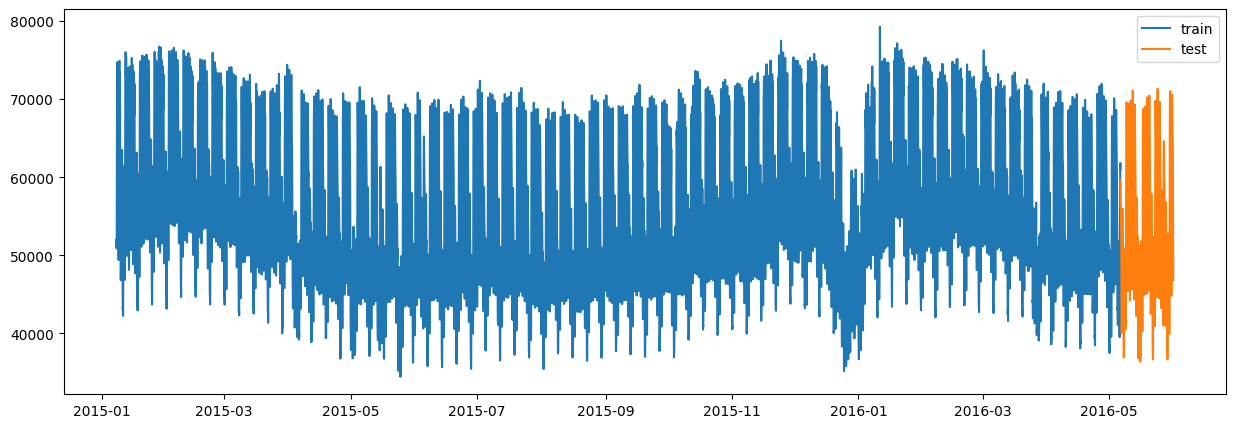

In [19]:
# take smaller dataset
start   = '2015-01-01'
end     = '2016-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
        
df = features_for_tree(df_energy_small, lags=[24, 7*24])
test_perc = 0.05

# - - - - - - - - - - - - - -
# train test split for random forests

n_total = df.shape[0]
n_train = int((1-test_perc) * n_total)
n_test = n_total - n_train

X_train = df.iloc[:n_train]
X_test = df.iloc[-n_test:]

y_train = X_train['gesamt']
y_test = X_test['gesamt']

X_train = X_train.drop(['gesamt'], axis=1)
X_test = X_test.drop(['gesamt'], axis=1)

# - - - - - - - - - - - - - -
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.legend()
plt.show()

#### param grid search

##### xgboost

In [13]:
# = = = = = = 
# XGBoost
# = = = = = = 

# cv_split = TimeSeriesSplit(n_splits=2, test_size=100)
# model = XGBRegressor()
# parameters = {
#     "max_depth": [3, 5, 10],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "n_estimators": [100, 200, 300],
#     "colsample_bytree": [0.3, 0.5, 0.8]
# }

# grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
# grid_search.fit(X_train, y_train)

# # Accessing the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# = = = = = = 
# Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# = = = = = = 

In [14]:
# # In-sample predictions 
# y_train_pred = xgboost_model.predict(X_train)
# # Out-of-sample predictions
# y_test_pred = xgboost_model.predict(X_test)

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 5))

# ax1.plot(y_train, label='actual')
# ax1.plot(y_train.index, y_train_pred, label='in sample predictions')

# ax2.plot(y_test, label='actual')
# ax2.plot(y_test.index, y_test_pred, label='out of sample predictions')

# plt.show()

##### lgbm

In [15]:
# = = = = = = 
# LGBM
# = = = = = = 

# cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
# model = lgb.LGBMRegressor()
# parameters = {
#     "max_depth": [3, 5, 10],
#     "num_leaves": [10, 50, 100],
#     "learning_rate": [0.01, 0.1, 0.3],
#     "n_estimators": [50, 200, 500],
#     "colsample_bytree": [0.3, 0.7, 1],
#     "verbose": [-1]
# }

# grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
# grid_search.fit(X_train, y_train)

# # Accessing the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# ERROR
# [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
# 1) the num_leaves is too large, you can set it to a smaller value
# 2) the min_data is too large
# 3) your data is hard to fit

# = = = = = = 
# Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 10, 'verbose': -1}
# = = = = = = 

In [16]:
# # In-sample predictions 
# y_train_pred = lgbm_model.predict(X_train)
# # Out-of-sample predictions
# y_test_pred = lgbm_model.predict(X_test)

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 5))

# ax1.plot(y_train, label='actual')
# ax1.plot(y_train.index, y_train_pred, label='in sample predictions')

# ax2.plot(y_test, label='actual')
# ax2.plot(y_test.index, y_test_pred, label='out of sample predictions')

# plt.show()

##### sklearn

In [137]:
# take smaller dataset
start   = '2015-01-01'
end     = '2017-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
        
print(df_energy_small.shape)

def get_train_test_data(df, test_perc=0.05):

    # - - - - - - - - - - - - - -
    # train test split for random forests

    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    return X_train, X_test, y_train, y_test

df = features_for_tree(df_energy_small, holiday_method='separate', lags=[24, 7*24])
X_train, X_test, y_train, y_test = get_train_test_data(df)

(21167, 2)


In [139]:
# = = = = = = 
# sklearn
# = = = = = = 

from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

cv_split = TimeSeriesSplit(n_splits=3, test_size=100)
model = GradientBoostingRegressor(loss="squared_error")
parameters = {
    "max_depth": [6, 7, 8],
    "learning_rate": [0.2, 0.3],
    "n_estimators": [250, 300, 400],
    'subsample': [0.8, 0.9],
    'min_samples_leaf': [5, 7]
}

# HistGradientBoostingRegressor uses different parameters
# ie n_estimators is not an input argument

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=5)
grid_search.fit(X_train, y_train)
# score closer to 1 is better !!!

# Accessing the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# = = = = = = 
# Best Parameters: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200, 'subsample': 0.9}
# - - - - - -
# 2015 -> 2017
# separate holidays, lags = [24, 7*24]
# Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 300, 'subsample': 0.9}
# - - - - - -
# 2015 -> 2017
# separate holidays, lags = [24, 7*24]

# = = = = = = 

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=250, subsample=0.8;, score=0.986 total time=  20.1s
[CV 2/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=250, subsample=0.8;, score=0.986 total time=  20.0s
[CV 3/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=250, subsample=0.8;, score=0.825 total time=  20.0s
[CV 1/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=250, subsample=0.9;, score=0.986 total time=  22.3s
[CV 2/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=250, subsample=0.9;, score=0.987 total time=  22.1s
[CV 3/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=250, subsample=0.9;, score=0.804 total time=  22.3s
[CV 1/3] END learning_rate=0.2, max_depth=6, min_samples_leaf=5, n_estimators=300, subsample=0.8;, score=0.986 total time=  23.9s
[CV 2/3] END learning_rate=0

In [98]:
# # In-sample predictions 
# y_train_pred = grid_search.predict(X_train)
# # Out-of-sample predictions
# y_test_pred = grid_search.predict(X_test)

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 5))

# ax1.plot(y_train, label='actual')
# ax1.plot(y_train.index, y_train_pred, label='in sample predictions')

# ax2.plot(y_test, label='actual')
# ax2.plot(y_test.index, y_test_pred, label='out of sample predictions')

# plt.show()

[[1.35167039e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.56899496e+06 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.38613063e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.60922000e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.11495604e+06 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.98593680e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


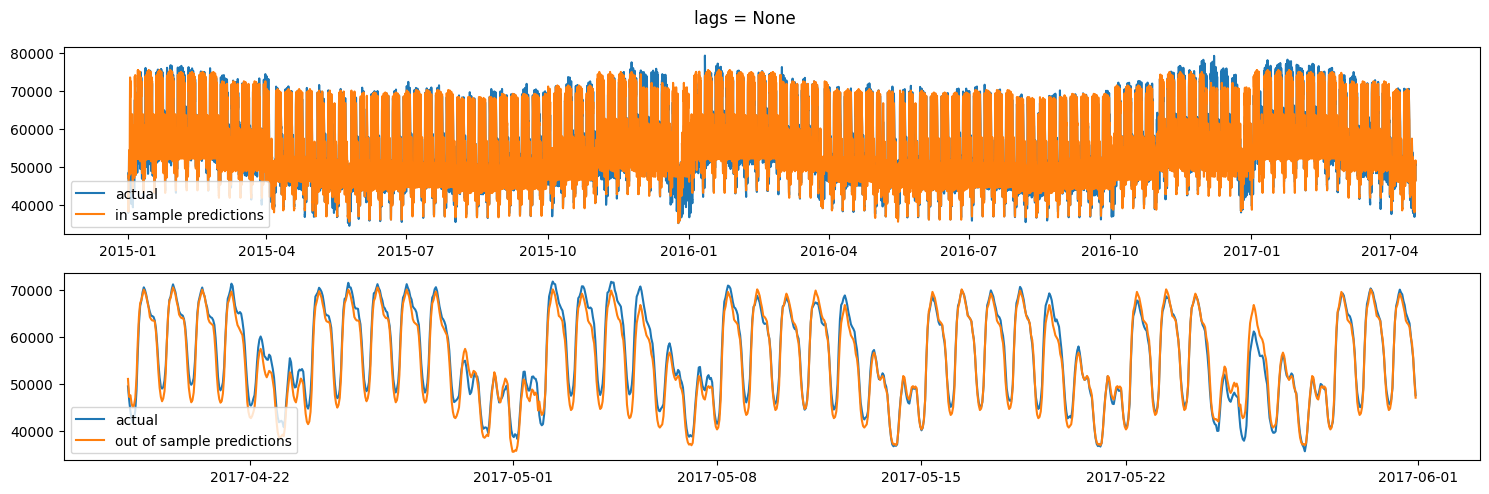

[[1.35167039e+03 4.38099711e+02 0.00000000e+00 0.00000000e+00]
 [4.56899496e+06 3.35579351e+05 0.00000000e+00 0.00000000e+00]
 [2.38613063e-02 7.73015553e-03 0.00000000e+00 0.00000000e+00]
 [1.60922000e+03 9.50082165e+02 0.00000000e+00 0.00000000e+00]
 [4.11495604e+06 1.65319787e+06 0.00000000e+00 0.00000000e+00]
 [2.98593680e-02 1.75643610e-02 0.00000000e+00 0.00000000e+00]]


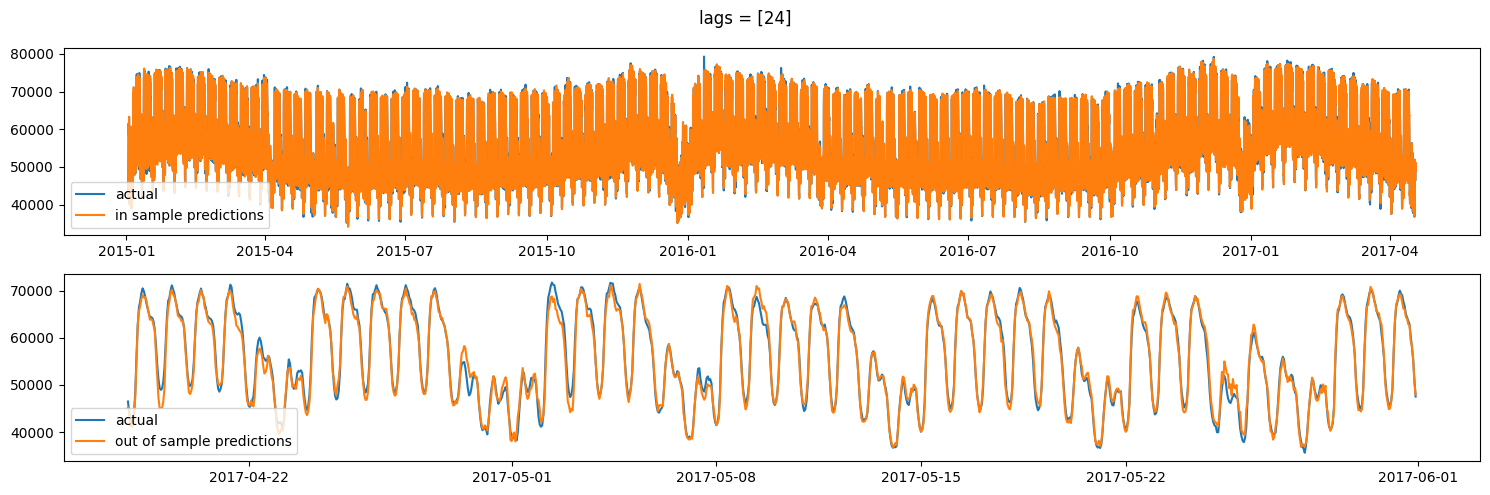

[[1.35167039e+03 4.38099711e+02 6.42480468e+02 0.00000000e+00]
 [4.56899496e+06 3.35579351e+05 7.23972957e+05 0.00000000e+00]
 [2.38613063e-02 7.73015553e-03 1.14278299e-02 0.00000000e+00]
 [1.60922000e+03 9.50082165e+02 1.65181282e+03 0.00000000e+00]
 [4.11495604e+06 1.65319787e+06 4.42918478e+06 0.00000000e+00]
 [2.98593680e-02 1.75643610e-02 3.03958229e-02 0.00000000e+00]]


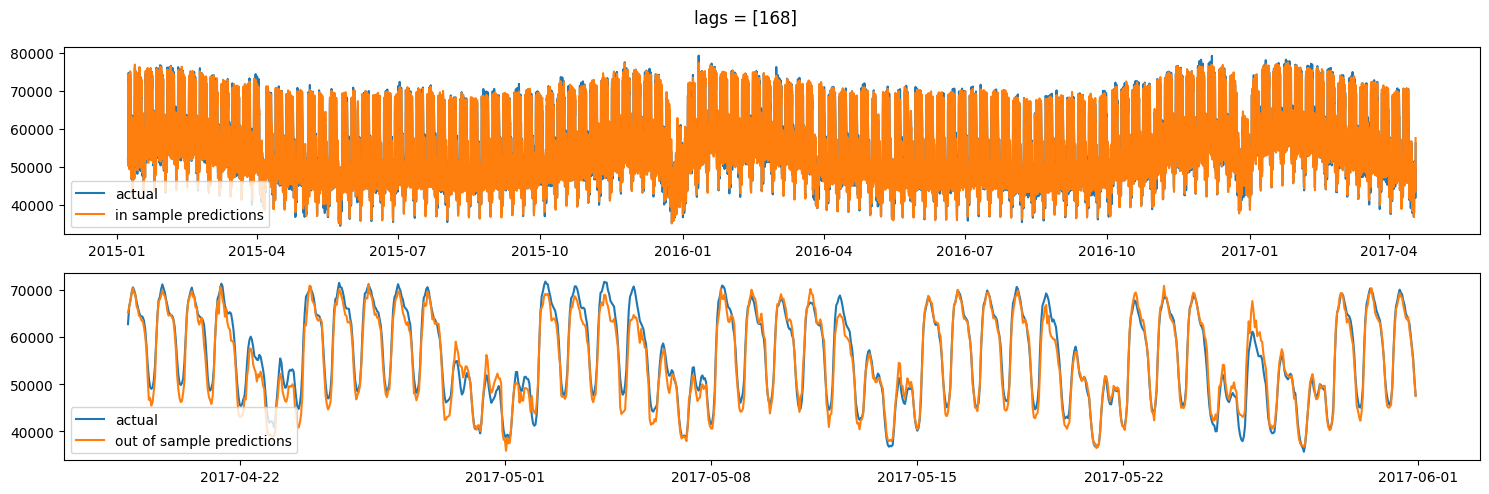

[[1.35167039e+03 4.38099711e+02 6.42480468e+02 3.56077591e+02]
 [4.56899496e+06 3.35579351e+05 7.23972957e+05 2.21132263e+05]
 [2.38613063e-02 7.73015553e-03 1.14278299e-02 6.32096897e-03]
 [1.60922000e+03 9.50082165e+02 1.65181282e+03 1.09377250e+03]
 [4.11495604e+06 1.65319787e+06 4.42918478e+06 2.19205855e+06]
 [2.98593680e-02 1.75643610e-02 3.03958229e-02 2.02687373e-02]]


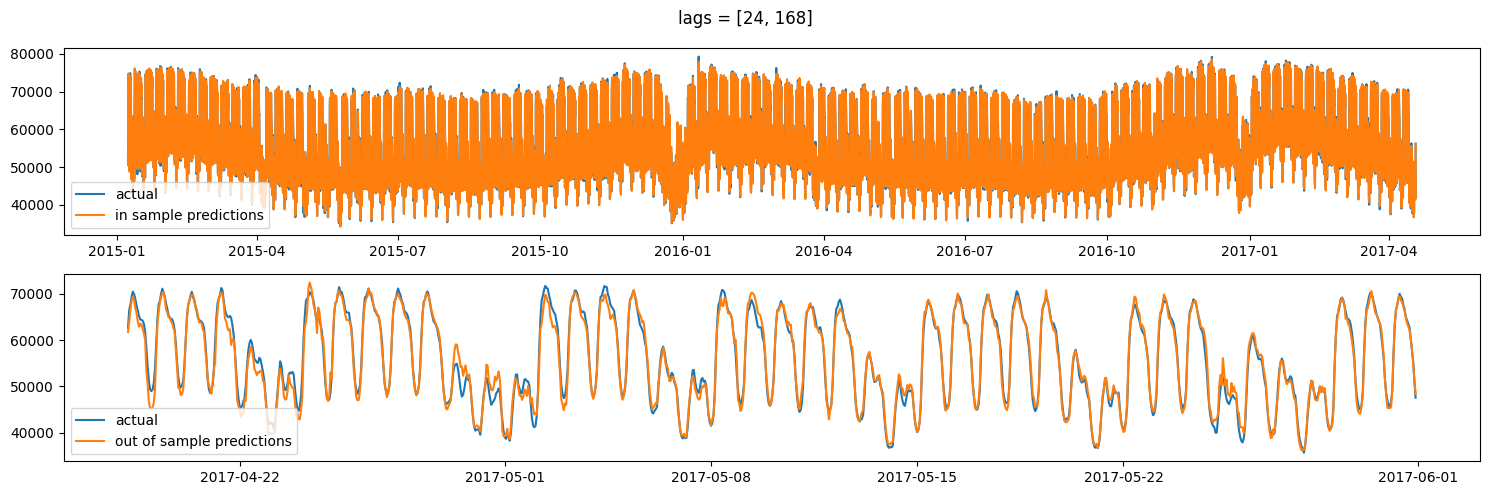

In [128]:
# take smaller dataset
start   = '2015-01-01'
end     = '2017-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
        
def get_train_test_data(df, test_perc=0.05):

    # - - - - - - - - - - - - - -
    # train test split for random forests

    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    return X_train, X_test, y_train, y_test

# - - - - - - - - - - - - - -

lag_meth_arr = [None, [24], [7*24], [24, 7*24]]

# results np matrix with columns = lag_meth_arr and rows = metrics
results_metrics = np.zeros((3*2, len(lag_meth_arr)))

for lag_idx, lag_meth in enumerate(lag_meth_arr) :

    df = features_for_tree(df_energy_small, lags=lag_meth)
    X_train, X_test, y_train, y_test = get_train_test_data(df)

    # = = = = = = 
    # sklearn - best model
    # = = = = = = 

    from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

    best_params = {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200, 'subsample': 0.9}

    model = GradientBoostingRegressor(loss="squared_error", **best_params)
    model.fit(X_train, y_train)

    # = = = = = = 
    # evaluation
    # = = = = = = 

    # In-sample predictions
    y_train_pred = model.predict(X_train)
    # Out-of-sample predictions
    y_test_pred = model.predict(X_test)

    # MAE in and out sample
    mae_in = mean_absolute_error(y_train, y_train_pred)
    mae_out = mean_absolute_error(y_test, y_test_pred)

    # MSE in and out sample
    mse_in = mean_squared_error(y_train, y_train_pred)
    mse_out = mean_squared_error(y_test, y_test_pred)

    # MAPE
    mape_in = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_out = mean_absolute_percentage_error(y_test, y_test_pred)

    results_metrics[:, lag_idx] = [mae_in, mse_in, mape_in, mae_out, mse_out, mape_out]
    print(results_metrics)
    
    # = = = = = = 
    # plot
    # = = = = = = 

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 5))

    ax1.plot(y_train, label='actual')
    ax1.plot(y_train.index, y_train_pred, label='in sample predictions')

    ax2.plot(y_test, label='actual')
    ax2.plot(y_test.index, y_test_pred, label='out of sample predictions')

    ax1.legend()
    ax2.legend()

    plt.suptitle(f"lags = {str(lag_meth)}")
    plt.tight_layout()
    plt.show()

In [130]:
# turn list of list elements lag_meth_arr into strings
lag_meth_arr_str = [str(lag_meth) for lag_meth in lag_meth_arr]

# put results_metrics into dataframe
results_metrics_df = pd.DataFrame(results_metrics, columns=lag_meth_arr_str)
# round all values to 2 decimals and remove trailing zeros
# results_metrics_df = results_metrics_df.round(2)
# row index = mae_in, mse_in, mape_in, mae_out, mse_out, mape_out
results_metrics_df.index = ['mae_in', 'mse_in', 'mape_in', 'mae_out', 'mse_out', 'mape_out']

# highlight min values in each row
results_metrics_df.style.highlight_min(axis=1)

,None,[24],[168],"[24, 168]"
mae_in,1351.670387,438.099711,642.480468,356.077591
mse_in,4568994.964874,335579.350733,723972.956824,221132.262830
mape_in,0.023861,0.007730,0.011428,0.006321
mae_out,1609.219998,950.082165,1651.812818,1093.772495
mse_out,4114956.039620,1653197.865874,4429184.777576,2192058.551574
mape_out,0.029859,0.017564,0.030396,0.020269


### [ALL] model fits n eval

#### data split

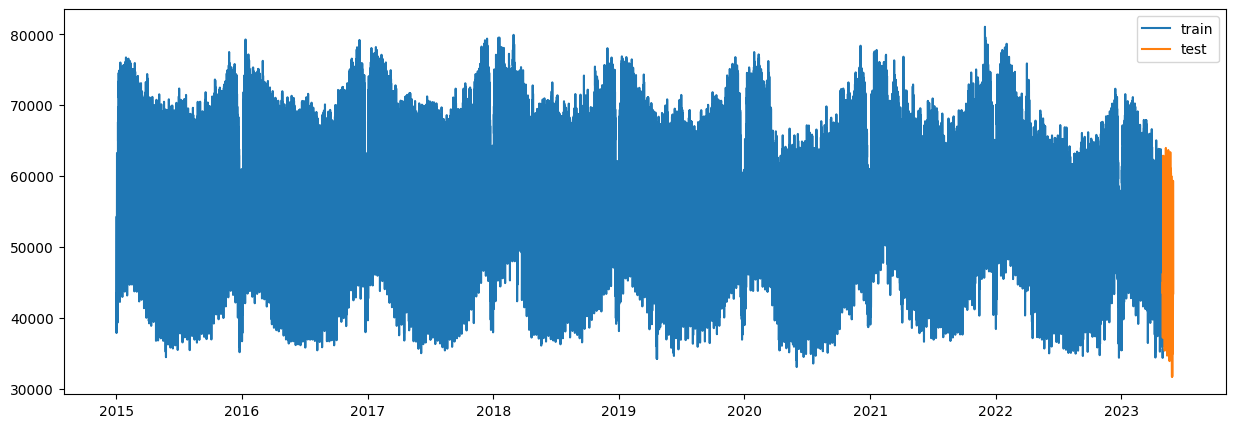

In [21]:
# take smaller dataset
start   = '2015-01-01'
end     = '2023-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
        
df = features_for_tree(df_energy_small)
test_perc = 0.01

# - - - - - - - - - - - - - -
# train test split for random forests

n_total = df.shape[0]
n_train = int((1-test_perc) * n_total)
n_test = n_total - n_train

X_train = df.iloc[:n_train]
X_test = df.iloc[-n_test:]

y_train = X_train['gesamt']
y_test = X_test['gesamt']

X_train = X_train.drop(['gesamt'], axis=1)
X_test = X_test.drop(['gesamt'], axis=1)

# - - - - - - - - - - - - - -
# train test split for regression

df = create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')

X_train_reg = df.iloc[:n_train].drop(['timestamp_CET', 'gesamt'], axis=1)
X_test_reg = df.iloc[-n_test:].drop(['timestamp_CET', 'gesamt'], axis=1)

X_train_reg = sm.add_constant(X_train_reg, has_constant='add').astype(float)
X_test_reg = sm.add_constant(X_test_reg, has_constant='add').astype(float)

# - - - - - - - - - - - - - -
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.legend()
plt.show()

#### fit

In [15]:
# Set LOKY_MAX_CPU_COUNT to the number of cores you want to use
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

# 1 = 15 - 26 sec
# 2 = 25 sec
# 3 = 37 sec
# 4 = 30 sec

In [22]:
# create model with best parameters
xgboost_model = XGBRegressor(colsample_bytree=0.5, 
                             learning_rate=0.1, 
                             max_depth=5, 
                             n_estimators=200)
xgboost_model.fit(X_train, y_train)

# create model with best parameters
lgbm_model = lgb.LGBMRegressor(colsample_bytree=1, 
                               learning_rate=0.3, 
                               max_depth=3, 
                               n_estimators=50, 
                               num_leaves=10, 
                               verbose=-1)
lgbm_model.fit(X_train, y_train)

# OLS models
ols_model = sm.OLS(y_train, X_train_reg)
ols_results = ols_model.fit()
elanet_results = ols_model.fit_regularized(method = 'elastic_net')

print('fit complete')

fit complete


Total number of trees: 200
0:[hour<7] yes=1,no=2,missing=2
	1:[hour<6] yes=3,no=4,missing=4
		3:[hour<5] yes=7,no=8,missing=8
			7:[hour<1] yes=13,no=14,missing=14
				13:leaf=-797.181702
				14:[hour<4] yes=19,no=20,missing=20
					19:leaf=-1037.25
					20:leaf=-967.098755
			8:leaf=-749.314514
		4:leaf=-284.975922
	2:[hour<21] yes=5,no=6,missing=6
		5:[hour<8] yes=9,no=10,missing=10
			9:leaf=96.1068344
			10:[hour<14] yes=15,no=16,missing=16
				15:[hour<10] yes=21,no=22,missing=22
					21:leaf=457.921692
					22:leaf=692.327576
				16:[hour<20] yes=23,no=24,missing=24
					23:leaf=445.447998
					24:leaf=213.692795
		6:[hour<23] yes=11,no=12,missing=12
			11:[hour<22] yes=17,no=18,missing=18
				17:leaf=13.8714218
				18:leaf=-222.98613
			12:leaf=-546.143616



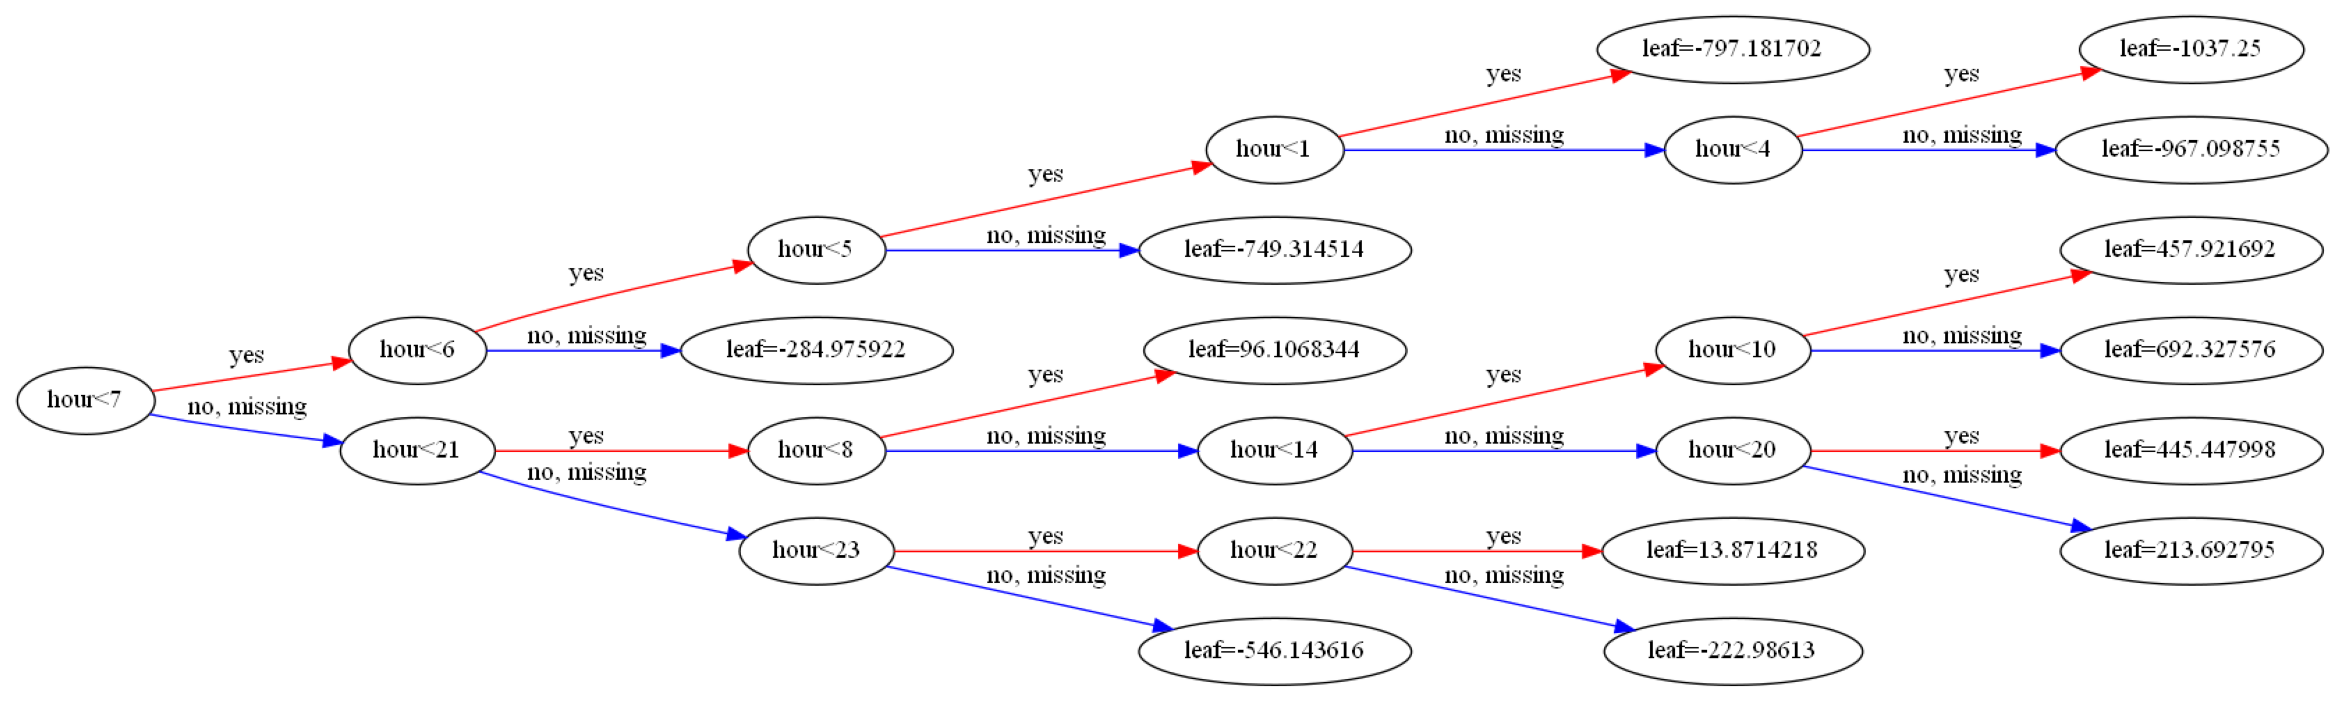

In [42]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

# Get a list of tree structures as text
booster = xgboost_model.get_booster()
tree_dump = booster.get_dump()

num_trees = len(tree_dump)
print(f"Total number of trees: {num_trees}")

# Print the weights of one tree
print(tree_dump[1])

# Alternatively plot the tree
fig, ax = plt.subplots(figsize=(30, 40))
plot_tree(xgboost_model, num_trees=1, rankdir='LR', ax=ax)  # rankdir='LR' for left-to-right orientation
plt.show()

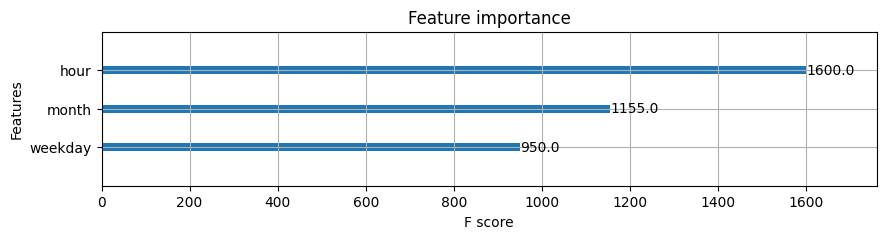

Feature Importance: {'hour': 1600.0, 'weekday': 950.0, 'month': 1155.0}


In [41]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 2))
xgb.plot_importance(booster, ax=ax)
plt.show()

# Alternatively, you can access the feature importance directly
feature_importance = booster.get_fscore()
print("Feature Importance:", feature_importance)

#### eval

Model: XGBoost
MAE  :         5120.82
RMSE :         6646.89
MAPE :          0.1115
- - - - - - - - - - 
Model: LGBM
MAE  :         5196.13
RMSE :         6774.67
MAPE :          0.1124
- - - - - - - - - - 
Model: ols_normal
MAE  :         5219.75
RMSE :         5939.23
MAPE :          0.1118
- - - - - - - - - - 
Model: ols_elanet
MAE  :         5235.35
RMSE :         5958.01
MAPE :          0.1121
- - - - - - - - - - 


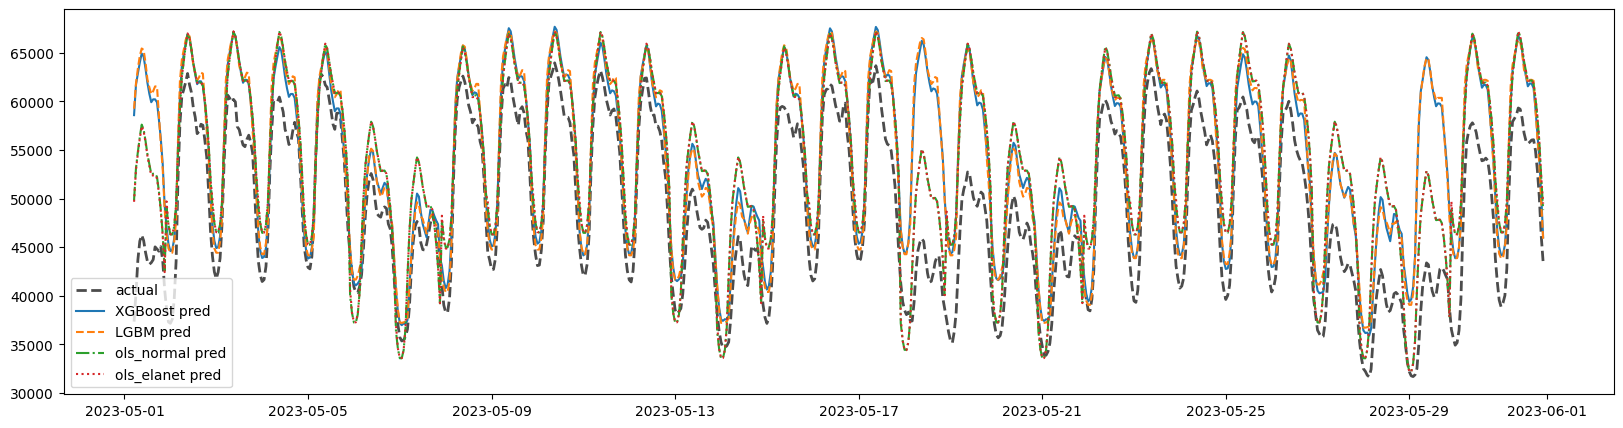

In [ ]:
models = [xgboost_model, lgbm_model, ols_results, elanet_results]
names = ['XGBoost', 'LGBM', 'ols_normal', 'ols_elanet']
linestyles = ['-', '--', '-.', ':']

plt.figure(figsize=(20, 5))
plt.plot(y_test, color='black', lw=2, ls='--', label='actual', alpha=0.7)

for model_idx, model in enumerate(models):
    
    model_name = names[model_idx]

    if model_name.startswith('ols') :

        # In-sample predictions 
        y_train_pred = model.predict(X_train_reg).astype(float)
        # Out-of-sample predictions
        y_test_pred = model.predict(X_test_reg).astype(float)

    else :

        # In-sample predictions 
        y_train_pred = model.predict(X_train)
        # Out-of-sample predictions
        y_test_pred = model.predict(X_test)

    print(f"Model: {names[model_idx]}")
    print(f"MAE  : {mean_absolute_error(y_test, y_test_pred):>15.2f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_test_pred)):>15.2f}")
    print(f"MAPE : {mean_absolute_percentage_error(y_test, y_test_pred):>15.4f}")
    print('- ' * 10)

    # iterate through linestyles for each model
    plt.plot(y_test.index, y_test_pred, ls=linestyles[model_idx], label=f'{names[model_idx]} pred')

plt.legend()
plt.show()


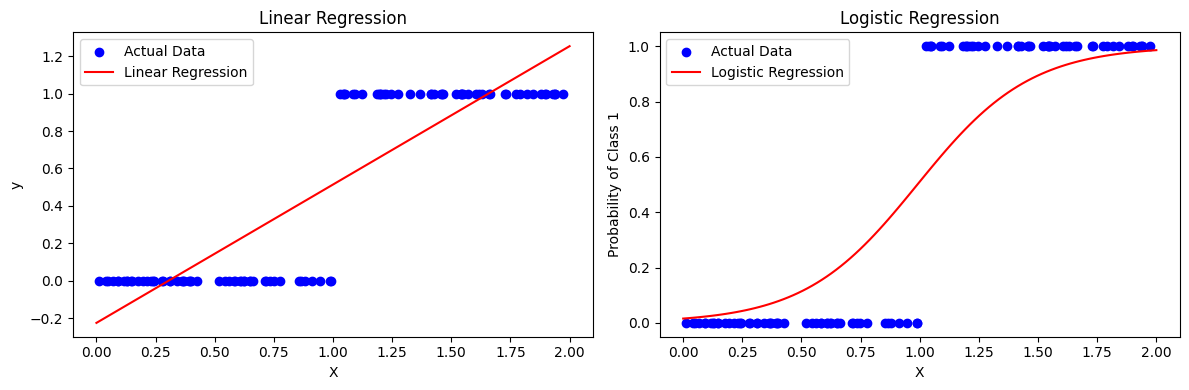

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Generate toy data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y_lin = 4 + 3 * X + np.random.randn(100, 1)
y_log = (X > 1).astype(int).flatten()

# - - - - - - - - - - - - - - - - - - - - - - - 
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y_lin)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X, y_log)

# - - - - - - - - - - - - - - - - - - - - - - - 
# Generate points for plotting the curves
X_pred = np.linspace(0, 2, 100).reshape(-1, 1)

# Predictions
y_lin_pred = lin_reg.predict(X_pred)
y_log_pred_proba = log_reg.predict_proba(X_pred)[:, 1]  # Probability of class 1 in binary classification

# Plotting
plt.figure(figsize=(12, 4))

# - - - - - - - - - - - - - - - - - - - - - - - 
# PLOTS 

# Linear Regression Plot
plt.subplot(1, 2, 1)
plt.scatter(X, y_lin, color='blue', label='Actual Data')
plt.plot(X_new, y_lin_pred, color='red', label='Linear Regression')
plt.title('Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# Logistic Regression Plot
plt.subplot(1, 2, 2)
plt.scatter(X, y_log, color='blue', label='Actual Data')
plt.plot(X_new, y_log_pred_proba, color='red', label='Logistic Regression')
plt.title('Logistic Regression')
plt.xlabel('X')
plt.ylabel('Probability of Class 1')
plt.legend()

plt.tight_layout()
plt.show()

# In the example code, y_log_pred_proba represents the predicted probabilities of belonging to class 1. 
# If you want to obtain binary predictions (0 or 1), you can apply a threshold. 
# For example, you can predict class 1 if the predicted probability is greater than 0.5
